### Import the Necessary Libraries : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
data = pd.read_csv('../input/air-passengers/AirPassengers.csv')
data.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

### Data Info :

In [3]:
data.shape

(144, 2)

In [4]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


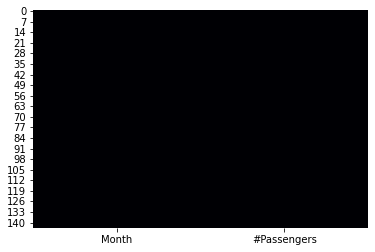

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

In [7]:
data.describe()

#Passengers
count       144.00
mean        280.30
std         119.97
min         104.00
25%         180.00
50%         265.50
75%         360.50
max         622.00

In [8]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

Passengers
Date                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

# <center>Time Series Analysis</center>

In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

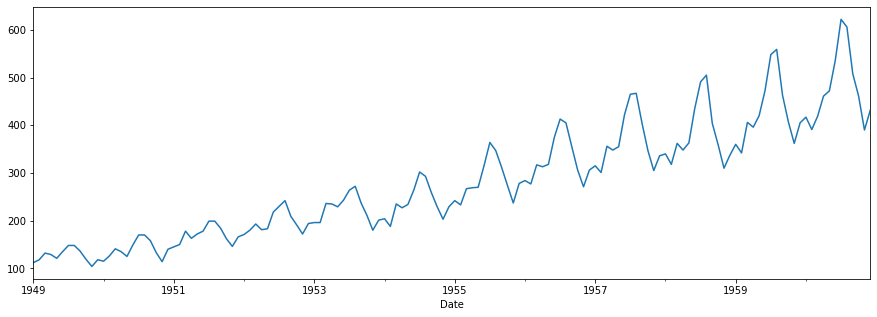

In [11]:
plt.figure(figsize = (15,5))
data['Passengers'].plot();

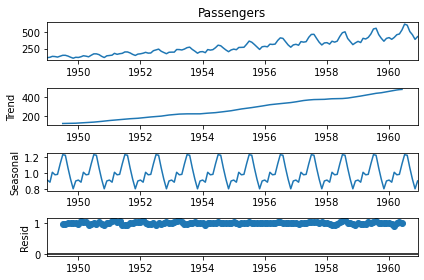

In [12]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

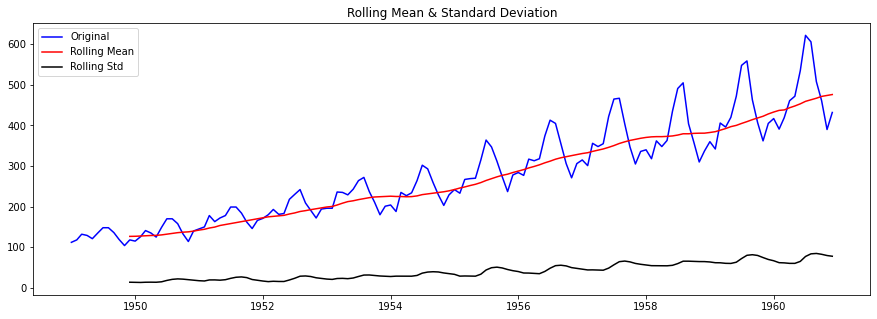

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [13]:
test_stationarity(data['Passengers'])

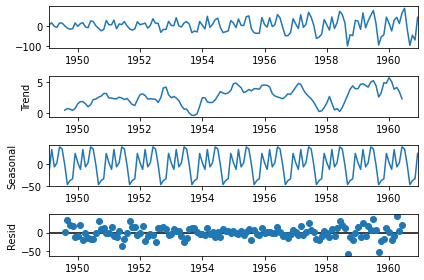

In [14]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

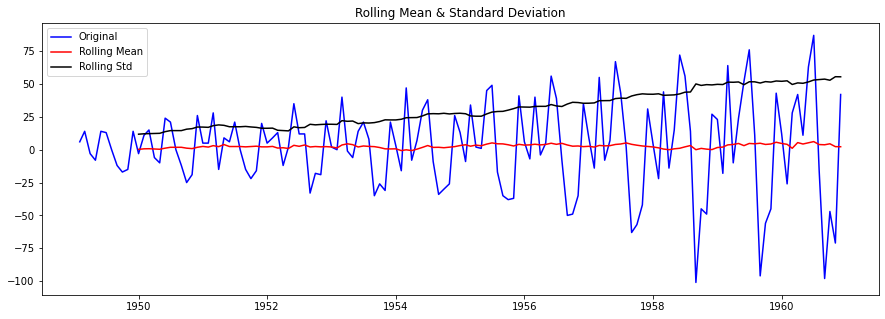

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [15]:
test_stationarity(data_diff)

# <center>Modeling</center>

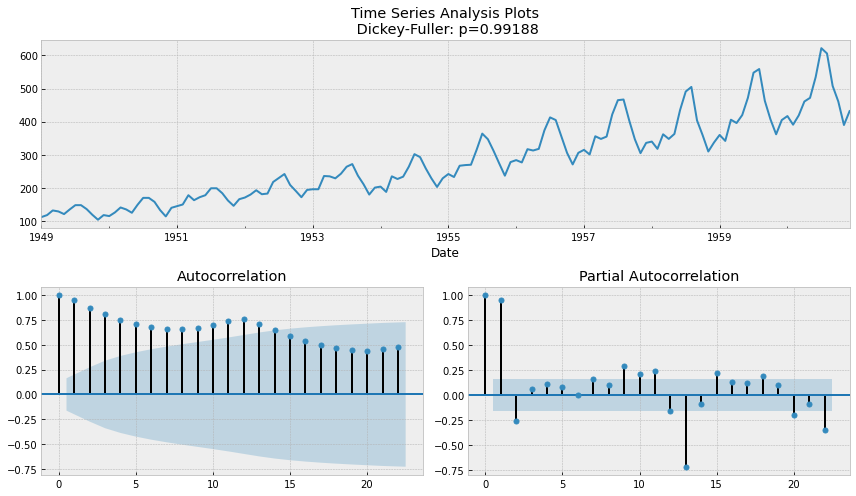

In [16]:
tsplot(data['Passengers'])

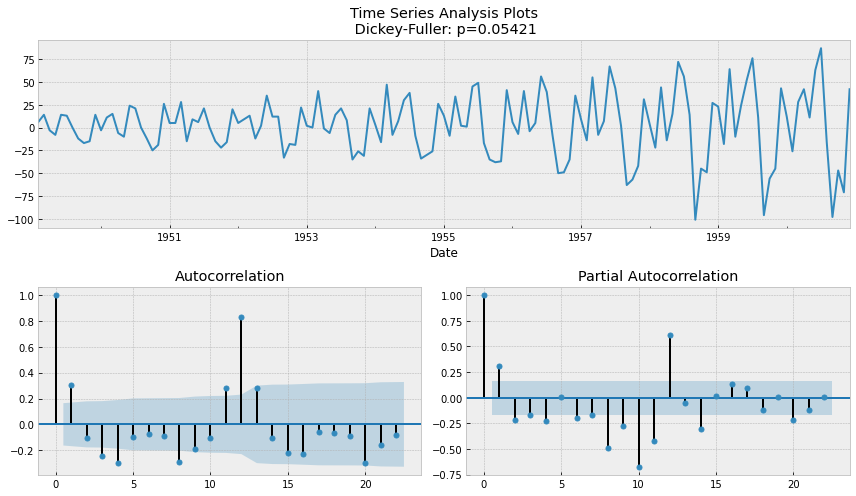

In [17]:
tsplot(data_diff['Passengers'])

In [18]:
model = ARIMA(data['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.712
Date:                Sun, 04 Aug 2024   AIC                           1344.043
Time:                        17:11:44   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5310      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Passengers  

In [19]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 433.264961, expected = 491.000000
predicted = 478.354780, expected = 505.000000
predicted = 474.554046, expected = 404.000000
predicted = 367.686905, expected = 359.000000
predicted = 386.044942, expected = 310.000000
predicted = 300.551746, expected = 337.000000
predicted = 342.709374, expected = 360.000000
predicted = 374.434590, expected = 342.000000
predicted = 368.418730, expected = 406.000000
predicted = 427.293724, expected = 396.000000
predicted = 416.580521, expected = 420.000000
predicted = 431.952319, expected = 472.000000
predicted = 465.574556, expected = 548.000000
predicted = 516.133943, expected = 559.000000
predicted = 522.643316, expected = 463.000000
predicted = 407.122886, expected = 407.000000
predicted = 367.581870, expected = 362.000000
predicted = 349.941716, expected = 405.000000
predicted = 415.817567, expected = 417.000000
predicted = 443.408002, expected = 391.000000
predicted = 432.877307, expected = 419.

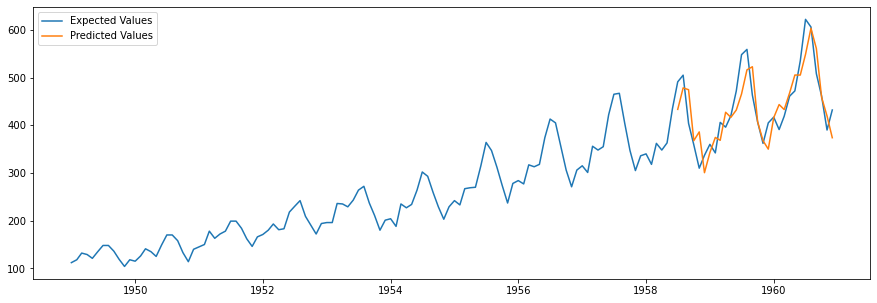

In [20]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [21]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 42.5167


In [22]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function
1949-01-01        112                      nan                     nan
1949-02-01        118                      nan                     nan
1949-03-01        132                      nan                     nan
1949-04-01        129                      nan                     nan
1949-05-01        121                      nan                     nan

#### Forecast Function : 

In [23]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()[0][0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[144 + i,1] = f1[i]
forecast.tail()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function
1961-10-05        NaN                   490.80                     nan
1961-10-12        NaN                   493.31                     nan
1961-10-19        NaN                   495.82                     nan
1961-10-26        NaN                   498.32                     nan
1961-11-02        NaN                   500.83                     nan

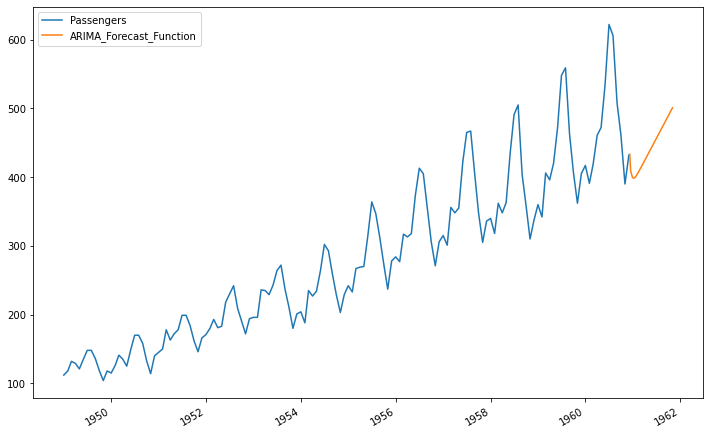

In [24]:
forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8));

#### Predict Function :

In [25]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = f2[i]
forecast.tail()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function
1961-10-05        NaN                   490.80                  490.80
1961-10-12        NaN                   493.31                  493.31
1961-10-19        NaN                   495.82                  495.82
1961-10-26        NaN                   498.32                  498.32
1961-11-02        NaN                   500.83                  500.83

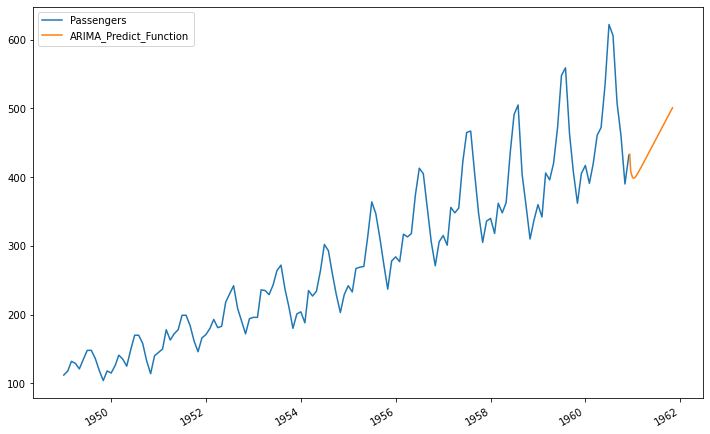

In [26]:
forecast[['Passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));

In [27]:
sum(f1) == sum(f2)

True

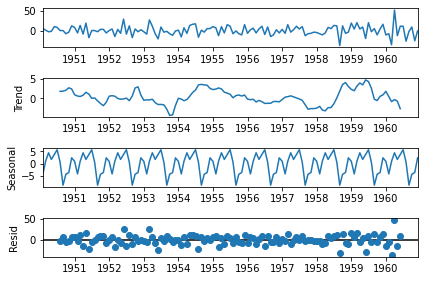

In [28]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

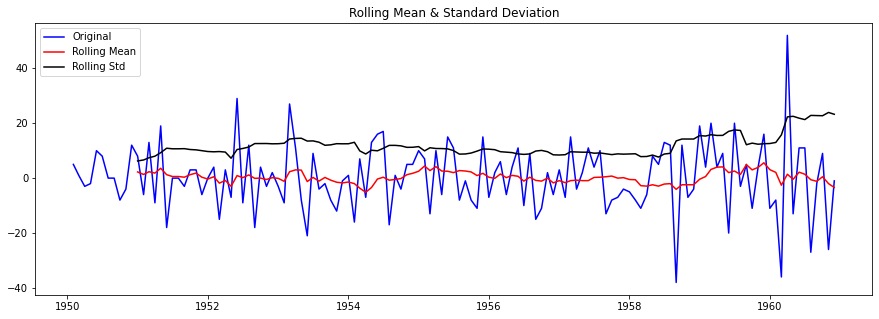

Results of Dickey-Fuller Test:
Test Statistic                -15.60
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [29]:
test_stationarity(data_diff_seas['Passengers'])

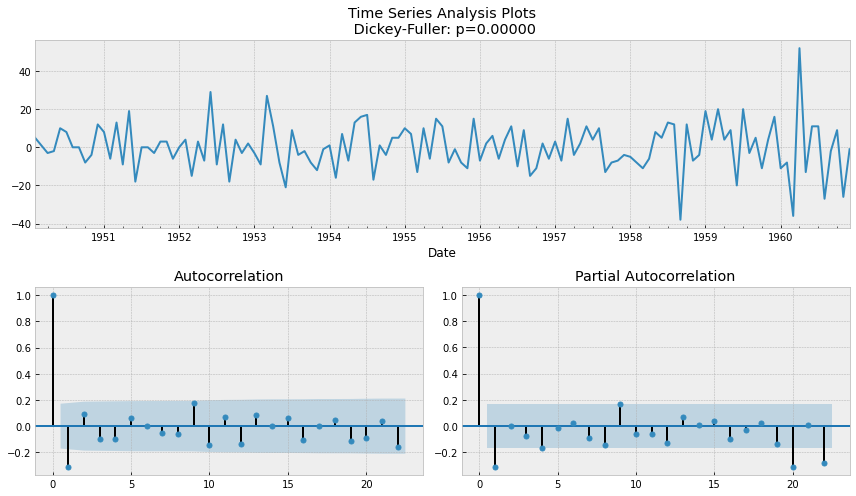

In [30]:
tsplot(data_diff_seas['Passengers'])

In [31]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Sun, 04 Aug 2024   AIC                           1019.935
Time:                                      17:12:27   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

In [32]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 479.086298, expected = 491.000000
predicted = 490.553512, expected = 505.000000
predicted = 441.276129, expected = 404.000000
predicted = 357.272983, expected = 359.000000
predicted = 315.251027, expected = 310.000000
predicted = 347.826920, expected = 337.000000


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted = 344.250923, expected = 360.000000
predicted = 336.836528, expected = 342.000000
predicted = 387.592863, expected = 406.000000
predicted = 387.333485, expected = 396.000000
predicted = 408.192791, expected = 420.000000
predicted = 485.988151, expected = 472.000000
predicted = 529.031345, expected = 548.000000
predicted = 551.914010, expected = 559.000000
predicted = 459.061271, expected = 463.000000
predicted = 411.970101, expected = 407.000000
predicted = 358.421154, expected = 362.000000
predicted = 384.945723, expected = 405.000000
predicted = 420.143977, expected = 417.000000
predicted = 397.755393, expected = 391.000000
predicted = 451.335513, expected = 419.000000
predicted = 415.675475, expected = 461.000000
predicted = 465.295962, expected = 472.000000
predicted = 529.835399, expected = 535.000000
predicted = 599.299659, expected = 622.000000
predicted = 626.292199, expected = 606.000000
predicted = 513.891978, expected = 508.000000
predicted = 450.136742, expected =

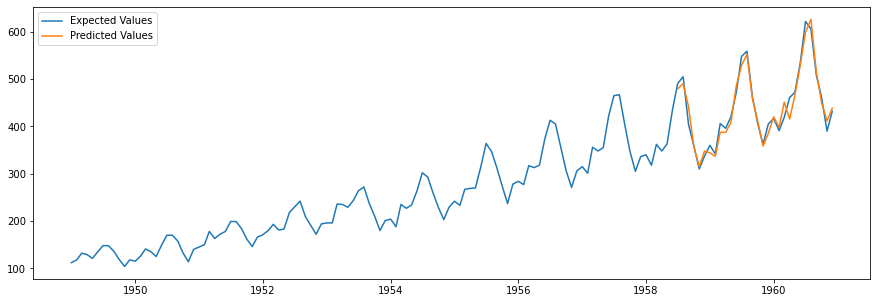

In [33]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [34]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9250


In [35]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function  \
1949-01-01        112                      nan                     nan   
1949-02-01        118                      nan                     nan   
1949-03-01        132                      nan                     nan   
1949-04-01        129                      nan                     nan   
1949-05-01        121                      nan                     nan   

            SARIMA_Forecast_Function  SARIMA_Predict_Function  
1949-01-01                       nan                      nan  
1949-02-01                       nan                      nan  
1949-03-01                       nan                      nan  
1949-04-01                       nan                      nan  
1949-05-01                       nan                      nan

#### Forecast Function :

In [36]:
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = f3[i]
forecast.tail()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function  \
1961-10-05        NaN                   490.80                  490.80   
1961-10-12        NaN                   493.31                  493.31   
1961-10-19        NaN                   495.82                  495.82   
1961-10-26        NaN                   498.32                  498.32   
1961-11-02        NaN                   500.83                  500.83   

            SARIMA_Forecast_Function  SARIMA_Predict_Function  
1961-10-05                    423.79                      nan  
1961-10-12                    469.38                      nan  
1961-10-19                    456.60                      nan  
1961-10-26                    471.07                      nan  
1961-11-02                    542.69                      nan

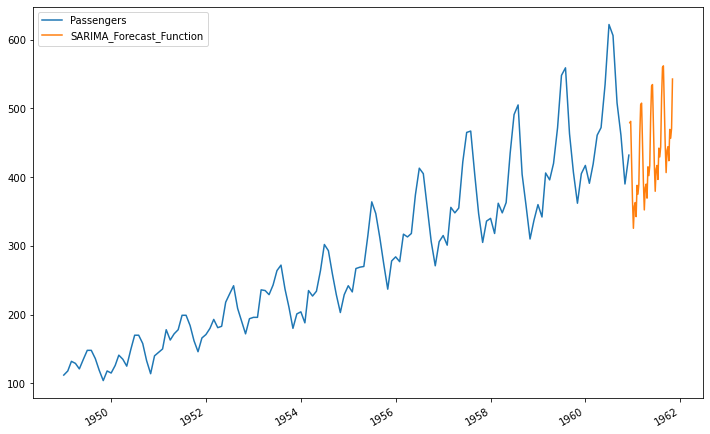

In [37]:
forecast[['Passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));

#### Predict Function :

In [38]:
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = f4[i]
forecast.tail()

Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function  \
1961-10-05        NaN                   490.80                  490.80   
1961-10-12        NaN                   493.31                  493.31   
1961-10-19        NaN                   495.82                  495.82   
1961-10-26        NaN                   498.32                  498.32   
1961-11-02        NaN                   500.83                  500.83   

            SARIMA_Forecast_Function  SARIMA_Predict_Function  
1961-10-05                    423.79                   423.79  
1961-10-12                    469.38                   469.38  
1961-10-19                    456.60                   456.60  
1961-10-26                    471.07                   471.07  
1961-11-02                    542.69                   542.69

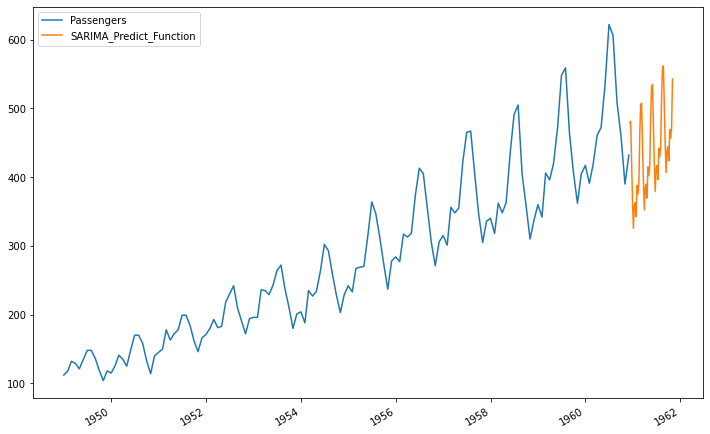

In [39]:
forecast[['Passengers','SARIMA_Predict_Function']].plot(figsize = (12,8));

In [40]:
sum(f3) == sum(f4)

True